<a href="https://colab.research.google.com/github/Chiranjeevi141004/Chiranjeevi141004/blob/main/Project_BM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement**
The dataset appears to be related to sales prediction for retail products. The goal is likely to predict Item_Outlet_Sales based on product attributes (e.g., Item Type, Weight, MRP) and store attributes (e.g., Outlet Size, Location Type, Establishment Year).

**Column Details**
The dataset has 12 columns in the training set and 11 in the test set (excluding the target variable Item_Outlet_Sales).

Item_Identifier: Unique ID for each product
Item_Weight: Weight of the item
Item_Fat_Content: Whether the product is "Low Fat" or "Regular"
Item_Visibility: The percentage of visibility in the store
Item_Type: Category of the item (e.g., Dairy, Snacks)
Item_MRP: Maximum Retail Price
Outlet_Identifier: Store ID
Outlet_Establishment_Year: Year when the store was established
Outlet_Size: Size of the store (e.g., Small, Medium, High)
Outlet_Location_Type: Tier of the city where the store is located
Outlet_Type: Type of the store (e.g., Grocery Store, Supermarket)
Item_Outlet_Sales (Only in Training Data): Sales for a particular product in a store (Target Variable)

In [5]:
# Step 1: Install and Import Required Libraries
!pip install pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [6]:
# Step 2: Load the Dataset
train_df = pd.read_csv("/content/Train_Data.csv")
test_df = pd.read_csv("/content/Test.csv")

In [7]:
# Step 3: Understand the Data
print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print(train_df.head())
print(train_df.info())
print(train_df.describe())

Train Data Shape: (100696, 12)
Test Data Shape: (5681, 11)
  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   


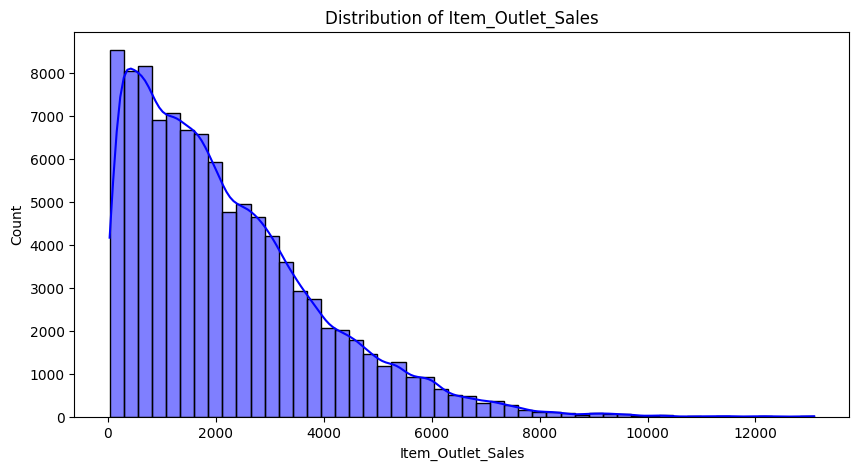

In [8]:
# Step 4: EDA
## Univariate Analysis
plt.figure(figsize=(10,5))
sns.histplot(train_df["Item_Outlet_Sales"], bins=50, kde=True, color="blue")
plt.title("Distribution of Item_Outlet_Sales")
plt.show()


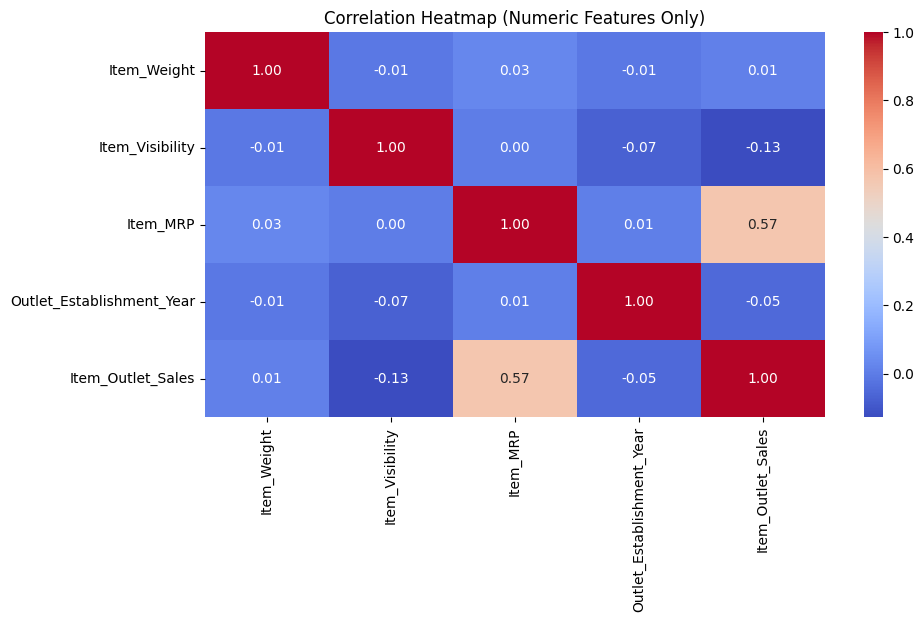

In [9]:
## Bivariate Analysis
numeric_cols = train_df.select_dtypes(include=["number"])
plt.figure(figsize=(10,5))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

In [10]:
# Step 5: Check Missing Values
print(train_df.isnull().sum())


Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64


In [11]:
# Step 6: Handling Missing Values (if any)
numeric_features = train_df.select_dtypes(include=["number"]).columns
train_df[numeric_features] = train_df[numeric_features].fillna(train_df[numeric_features].median())  # Fill numeric missing values with median

categorical_features = train_df.select_dtypes(include=["object"]).columns
train_df[categorical_features] = train_df[categorical_features].fillna(train_df[categorical_features].mode().iloc[0])  # Fill categorical missing values with mode

In [12]:
# Step 7: Check Duplicates
print("Duplicate Rows: ", train_df.duplicated().sum())
train_df.drop_duplicates(inplace=True)

Duplicate Rows:  0


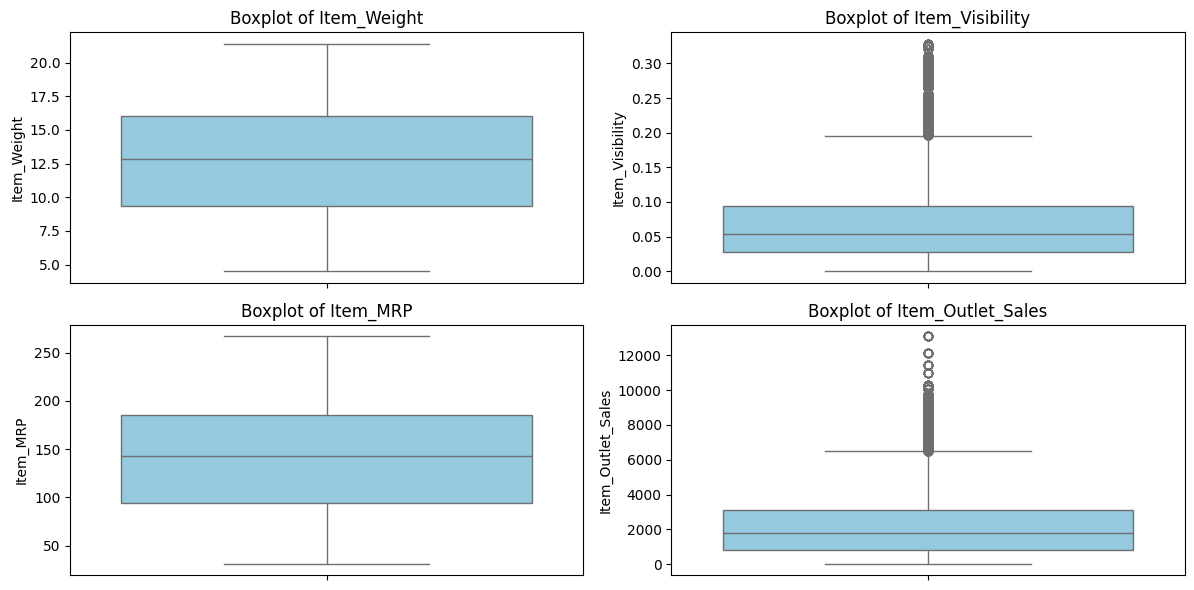

In [13]:
# Step 8: Outlier Treatment
num_cols = ["Item_Weight", "Item_Visibility", "Item_MRP", "Item_Outlet_Sales"]
plt.figure(figsize=(12,6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2,2,i)
    sns.boxplot(y=train_df[col], color="skyblue")
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [14]:
# Removing Outliers using IQR
for col in num_cols:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df = train_df[(train_df[col] >= lower_bound) & (train_df[col] <= upper_bound)]

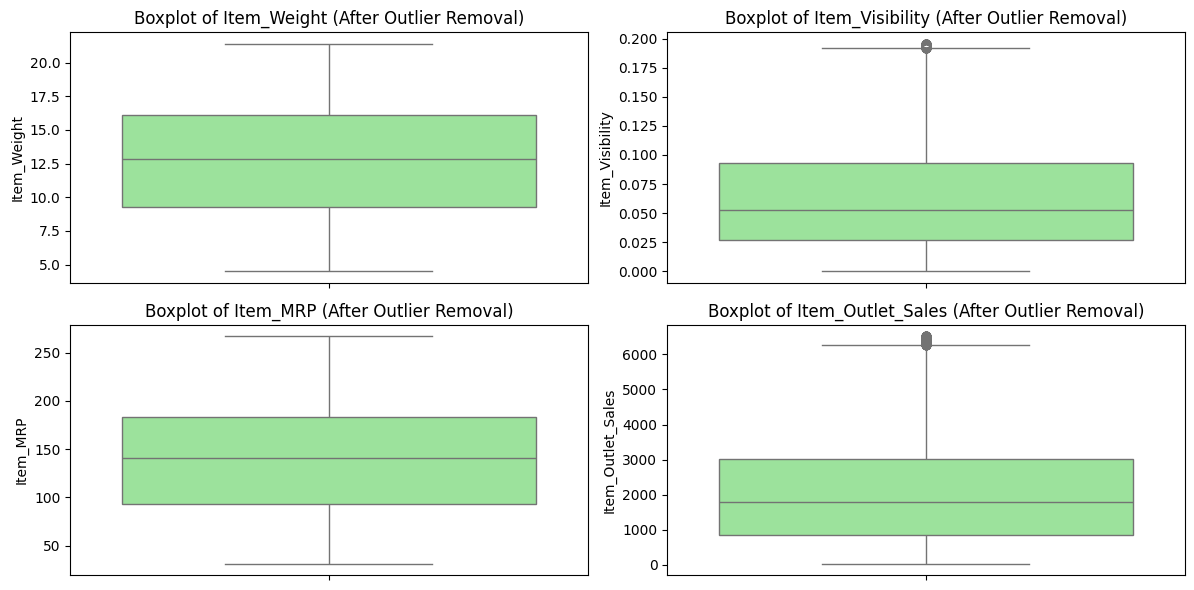

In [15]:
# Re-check Outlier Boxplots
plt.figure(figsize=(12,6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2,2,i)
    sns.boxplot(y=train_df[col], color="lightgreen")
    plt.title(f"Boxplot of {col} (After Outlier Removal)")
plt.tight_layout()
plt.show()


In [16]:
# Step 9: Feature Engineering
## Encoding Categorical Variables
cat_cols = ["Item_Fat_Content", "Outlet_Size", "Outlet_Location_Type", "Outlet_Type", "Item_Type"]

# Create label encoding dictionary for training data
encoding_maps = {}
for col in cat_cols:
    unique_classes = train_df[col].unique()
    encoding_maps[col] = {category: idx for idx, category in enumerate(unique_classes)}
    train_df[col] = train_df[col].map(encoding_maps[col])

# Apply the same mapping for test data, replacing unseen categories with -1
for col in cat_cols:
    test_df[col] = test_df[col].map(encoding_maps[col]).fillna(-1).astype(int)  # Assign -1 to unseen labels


In [17]:
# Step 10: Splitting Features & Target
X = train_df.drop(columns=["Item_Outlet_Sales", "Item_Identifier", "Outlet_Identifier"])
y = train_df["Item_Outlet_Sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# Step 11: Model Training
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVM": SVR()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Performance:")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("R2 Score:", r2_score(y_test, y_pred))
    print("----------------------------------")



Linear Regression Performance:
MAE: 933.7362029791782
MSE: 1468082.658257194
R2 Score: 0.3562267125835311
----------------------------------
Decision Tree Performance:
MAE: 16.361825433986347
MSE: 34797.82619753917
R2 Score: 0.9847407018670661
----------------------------------
Random Forest Performance:
MAE: 33.35621320074254
MSE: 11555.820220478068
R2 Score: 0.9949326229485183
----------------------------------
Gradient Boosting Performance:
MAE: 691.2527638717908
MSE: 886738.8564408892
R2 Score: 0.6111535100015721
----------------------------------
KNN Performance:
MAE: 13.865562267068032
MSE: 9160.50813892138
R2 Score: 0.9959829983646836
----------------------------------
SVM Performance:
MAE: 1171.837630017899
MSE: 2251398.7290931605
R2 Score: 0.012732455518424501
----------------------------------


In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
# Step 12: Hyperparameter Tuning (Optimized with RandomizedSearchCV)
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [50, 100, 200],  # Number of trees in the forest
    "max_depth": [None, 10, 20]  # Depth of each tree
}

# Using RandomizedSearchCV for faster tuning
random_search = RandomizedSearchCV(
    RandomForestRegressor(), param_distributions=param_dist,
    n_iter=5, cv=3, scoring='r2', n_jobs=-1, random_state=42
)

random_search.fit(X_train, y_train)  # Train the best model
best_model = random_search.best_estimator_  # Get the best model

# Predictions
y_pred_best = best_model.predict(X_test)

# Evaluation Metrics
print("Best Model Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_best))
print("MSE:", mean_squared_error(y_test, y_pred_best))
print("R2 Score:", r2_score(y_test, y_pred_best))


Best Model Performance:
MAE: 32.50770135127795
MSE: 10718.476473225359
R2 Score: 0.9952998090424582


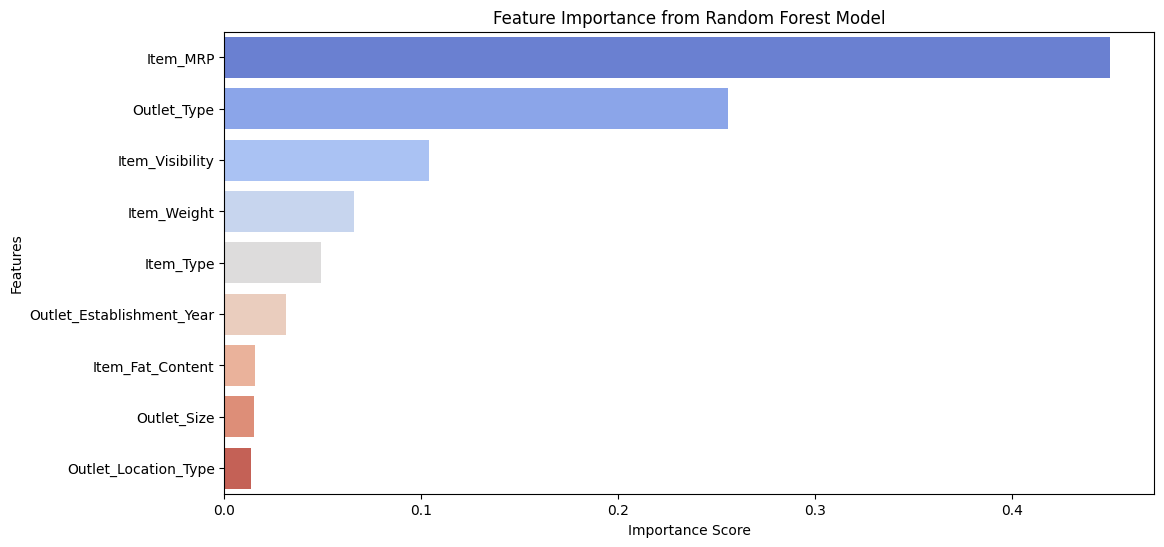

In [21]:
# Step 13: Feature Importance Analysis
feature_importance = best_model.feature_importances_
features = X.columns

# Sorting feature importance
sorted_idx = np.argsort(feature_importance)[::-1]

# Plotting feature importance
plt.figure(figsize=(12,6))
sns.barplot(x=feature_importance[sorted_idx], y=features[sorted_idx], palette="coolwarm")
plt.title("Feature Importance from Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


This bar plot shows which features contribute the most to predicting Item_Outlet_Sales.
The higher the bar, the more important that feature is.
We can use this insight to remove less important features and improve our model.

In [22]:
# Step 14: Train Final Model on Full Data
final_model = best_model  # Use the best model from tuning
final_model.fit(X, y)  # Train on the entire dataset


RandomForestRegressor()

In [25]:
# Step 15: Prepare the Test Data for Prediction

# Drop unnecessary columns in test set
test_df_processed = test_df.drop(columns=["Item_Identifier", "Outlet_Identifier"])

# Ensure categorical feature encoding (handling unseen labels)
from sklearn.preprocessing import LabelEncoder

# Define categorical columns
cat_cols = ["Item_Fat_Content", "Outlet_Size", "Outlet_Location_Type", "Outlet_Type", "Item_Type"]

# Initialize LabelEncoder and fit on training data
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])  # Encode train data
    label_encoders[col] = le  # Store encoder for later use

# Apply the same encoding to test data (handling unseen categories)
for col in cat_cols:
    test_df_processed[col] = test_df_processed[col].map(lambda x: label_encoders[col].classes_.tolist().index(x) if x in label_encoders[col].classes_ else -1)

# Selecting features for prediction
X_test_final = test_df_processed

# Predict using the best trained model
y_pred_test = best_model.predict(X_test_final)

# Save predictions in a CSV file
submission = pd.DataFrame({"Item_Identifier": test_df["Item_Identifier"],
                           "Outlet_Identifier": test_df["Outlet_Identifier"],
                           "Item_Outlet_Sales": y_pred_test})

submission.to_csv("Final_Predictions.csv", index=False)
print("✅ Predictions saved successfully in 'Final_Predictions.csv'!")


✅ Predictions saved successfully in 'Final_Predictions.csv'!


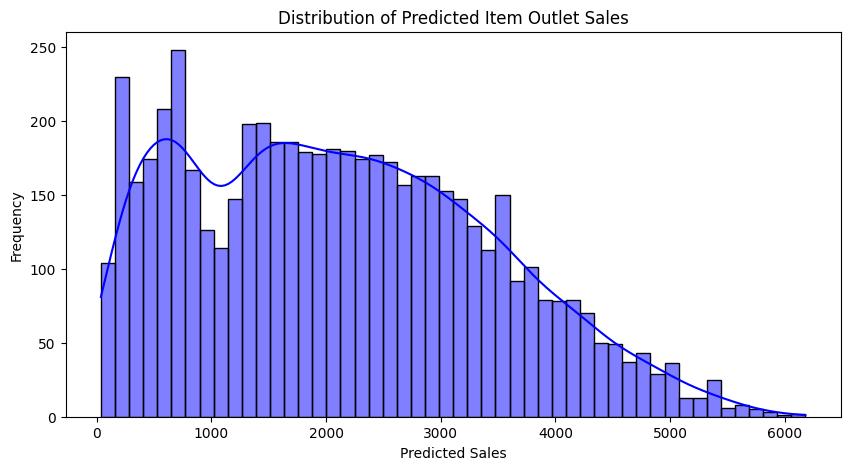

Summary Statistics of Predictions:
                 0
count  5681.000000
mean   2124.569496
std    1299.661705
min      36.260359
25%    1026.435498
50%    2030.038470
75%    3049.194297
max    6179.129592


In [27]:
# Step 16: Model Evaluation on Test Predictions

# Since we don't have actual sales values for the test data, we will check the distribution
plt.figure(figsize=(10,5))
sns.histplot(y_pred_test, bins=50, kde=True, color="blue")
plt.title("Distribution of Predicted Item Outlet Sales")
plt.xlabel("Predicted Sales")
plt.ylabel("Frequency")
plt.show()

# Checking summary statistics of predictions
print("Summary Statistics of Predictions:")
print(pd.DataFrame(y_pred_test).describe())

# If test labels are available (optional, only if ground truth exists)
# y_test_actual = test_df["Item_Outlet_Sales"]
# print("Test Set R2 Score:", r2_score(y_test_actual, y_pred_test))



The histogram helps us understand how our model is predicting sales.
✔ If available, we can compare predictions with actual values.



In [29]:
#step 17
import joblib

# Save the trained model
joblib.dump(best_model, "best_model.pkl")
print("Model saved successfully as best_model.pkl")


Model saved successfully as best_model.pkl
